# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Изучение данных

Для начала загрузим библиотеки, которые нам понадобятся в процессе работы, после загрузим и ознакомимся с данными:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import collections
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


В таблице 354369 объектов, 16 признаков, ключевой для нас Price

In [5]:
df.isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False)

,sum,mean
NotRepaired,71154.0,0.200791
VehicleType,37490.0,0.105794
FuelType,32895.0,0.092827
Gearbox,19833.0,0.055967
Model,19705.0,0.055606
DateCrawled,0.0,0.000000
Price,0.0,0.000000
RegistrationYear,0.0,0.000000
Power,0.0,0.000000
Kilometer,0.0,0.000000


В 5 признаках значительное количество пропусков, больше 5%, необходимо будет изучить и принять решение

In [6]:
for row in df: 
      print(df[row].value_counts())

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-08 15:50:29    5
2016-04-01 19:25:23    5
                      ..
2016-03-28 10:52:24    1
2016-03-21 19:58:08    1
2016-04-04 11:37:39    1
2016-03-16 17:50:55    1
2016-03-16 12:50:26    1
Name: DateCrawled, Length: 271174, dtype: int64
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: RegistrationYear, Length: 151, dtype: int64
manual    268251
auto       66285
Name: Gearbox, dtype: int64
0     

RegistrationYear - много значений введенных наугад  
RegistrationMonth - у многих указан 0 (по факту не указан)  
NumberOfPictures - везде 0  
Power - много указано 0, видимо автозаполнение при отсутствии данных, также  часть указаны явно некоректно  
Price - 10772 значения 0, явно речь не о подарке


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


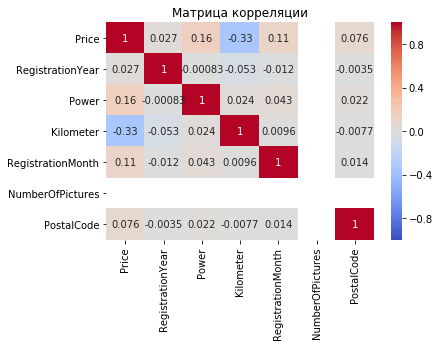

In [8]:
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Матрица корреляции");

Матрица корреляции на данном этапе ценной информации не даёт, исходя из нашей цели нет необходимости в дальнейшем анализе зависимостей

Определимся со значимыми признаками:

- VehicleType — тип автомобильного кузова влияет на характеристики цену    
- RegistrationYear — год регистрации автомобиля определяет его возраст и возможный износ, влияет на цену  
- Gearbox — тип коробки передач определяет удобство и стоимость эксплуатации, влияет на цену   
- Power — мощность (л. с.), влияет на цену   
- Model — модель автомобиля определяет множество параметров автомобиля, влияет на цену   
- Kilometer — пробег (км) определяет износ автомобиля, чем выше он, тем ниже цена  
- FuelType — тип топлива определяет стоимость экплуатации и другие характеристики, влияет на цену  
- Brand — марка автомобиля оказывает существенное влияние на цену через эмоции историю или её отсутствие  
- NotRepaired — была машина в ремонте или нет, влияет на цену   


DateCrawled, RegistrationMonth, DateCreated, PostalCode, NumberOfPictures, LastSeen - не являются характеристиками самого автомобиля.     Важно что даты создания анкет и скачивания близки между собой, нет цен годовой давности. Все эти характеристики можно отбросить.




### Предобработка данных

Оставим только значимые и целевой признаки

In [9]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [10]:
fg = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'NotRepaired']]
fg

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Поправим год регистрации, он не может быть больше даты регистрации анкет и меньше  начала 20 века, назначим всем таким датам одно значение 1900

In [11]:
def Year(y):
    if 1900 < y < 2017:
        return y
    else:
        return 1900
    
fg["RegistrationYear"] = fg["RegistrationYear"].apply(Year)

In [12]:
fg["RegistrationYear"]

0         1993
1         2011
2         2004
3         2001
4         2008
          ... 
354364    2005
354365    2005
354366    2000
354367    1996
354368    2002
Name: RegistrationYear, Length: 354369, dtype: int64

Отбросим нулевые значения цены, которые для нашей цели в любом случае не будут полезны. Остальные данные оставим, модель сама определит их ценность.

In [13]:
fg = fg.query('Price > 0')

Заполним отсутствующие значения в Gearbox, NotRepaired и Model:  
- большинство машин с ручной коробкой передач, можно уверенно предположить, что в анкете пользователь бы указал о наличии автомата для обоснования цены, по умолчанию укажем ручную  
- согласно большинству объявлений, автомобиль не был восстановлен после аварии, также заполним пропуски модой  
- модель может быть не указана по разным причинам, при этом она играет важную роль в цене автомобиля, укажем, что модель неизвестна

In [14]:
fg.fillna({'Gearbox':'manual',
           'NotRepaired':'yes',
           'Model':'unknown'},
          inplace=True)

In [15]:
fg

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354365,2200,NaN,2005,manual,0,unknown,20000,NaN,sonstige_autos,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Проведем замену столбцов Gearbox и NotRepaired на булев тип.

- IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
- IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [16]:
fg['IsManualGearbox'] = 0
fg.loc[fg['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
fg['IsNotRepaired'] = 0
fg.loc[fg['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1

In [17]:
fg

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,IsManualGearbox,IsNotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,yes,1,1
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,1,1
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes,0,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,1,0
354365,2200,NaN,2005,manual,0,unknown,20000,NaN,sonstige_autos,yes,1,1
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,0,0
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,1,0


In [18]:
fg.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)

In [19]:
fg.isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False)

,sum,mean
VehicleType,33750.0,0.098226
FuelType,29459.0,0.085737
Price,0.0,0.000000
RegistrationYear,0.0,0.000000
Power,0.0,0.000000
Model,0.0,0.000000
Kilometer,0.0,0.000000
Brand,0.0,0.000000
IsManualGearbox,0.0,0.000000
IsNotRepaired,0.0,0.000000


Посмотрим внимательнее на возможность определения типа кузова и топлива в зависимости от марки

In [20]:
VehicleType = fg.pivot_table(index=['VehicleType'],columns=['Brand'],values=['Price'],aggfunc=['count'])
VehicleType

count                                                      \
                 Price                                                       
Brand       alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                  
bus                NaN     10.0      6.0     156.0    415.0  1252.0   50.0   
convertible      177.0   1612.0   3199.0      17.0    228.0   112.0    NaN   
coupe            226.0   1464.0   3683.0      89.0     47.0   148.0    NaN   
other             14.0    107.0    224.0      43.0      9.0   114.0    6.0   
sedan            912.0  10677.0  17224.0     223.0    279.0   693.0  100.0   
small            235.0   1538.0    437.0     580.0     12.0  1570.0  221.0   
suv                NaN    177.0    805.0     377.0     23.0    36.0  214.0   
wagon            451.0  10827.0   7763.0     105.0    241.0   617.0  251.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           27.0     34.0   818.0  ...   610.0   231.0     1.0   
convertible    1.0     17.0   506.0  ...     NaN     4.0  1126.0   
coupe          8.0      NaN   168.0  ...    84.0    10.0   338.0   
other          5.0     10.0   178.0  ...    62.0    26.0     9.0   
sedan        105.0     47.0   877.0  ...  1738.0   904.0    28.0   
small        265.0    512.0  5192.0  ...  3060.0  1115.0  3232.0   
suv            1.0     46.0    24.0  ...     4.0   173.0     NaN   
wagon         46.0     16.0   444.0  ...   387.0  2684.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  187.0   17.0   27.0   446.0     NaN     9388.0     NaN  
convertible          322.0    1.0   35.0    63.0    36.0     2887.0    75.0  
coupe                222.0    8.0    7.0   222.0     3.0     1725.0    67.0  
other                217.0    6.0   14.0    19.0     5.0      722.0     5.0  
sedan                465.0  164.0  178.0   887.0   201.0    19299.0   635.0  
small                240.0  117.0  967.0  1580.0    54.0    17979.0     7.0  
suv                  422.0   59.0  743.0   439.0     1.0     1308.0   219.0  
wagon                123.0  292.0   87.0   568.0    71.0    12374.0  1934.0  

[8 rows x 40 columns]

In [21]:
FuelType = fg.pivot_table(index=['FuelType'],columns=['Brand'],values=['Price'],aggfunc=['count'])
FuelType

count                                                      \
              Price                                                       
Brand    alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
FuelType                                                                  
cng             NaN      1.0     10.0       4.0      NaN     8.0    2.0   
electric        NaN      2.0      3.0       NaN      NaN     1.0    NaN   
gasoline      598.0  12213.0  11966.0     236.0    377.0  1594.0  206.0   
hybrid          NaN      2.0      NaN       NaN      NaN     NaN    NaN   
lpg            37.0    451.0    750.0     177.0     93.0    70.0   53.0   
other           NaN      4.0      8.0       1.0      NaN     3.0    NaN   
petrol       1406.0  13899.0  20478.0    1152.0    789.0  2965.0  573.0   

                                  ...                                         \
                                  ...                                          
Brand    daewoo daihatsu    fiat  ...    seat   skoda   smart sonstige_autos   
FuelType                          ...                                          
cng         NaN      NaN    68.0  ...     3.0     6.0     3.0            7.0   
electric    NaN      1.0     4.0  ...     NaN     NaN     7.0           21.0   
gasoline    1.0      4.0  1492.0  ...  1676.0  1912.0   868.0          441.0   
hybrid      NaN      NaN     3.0  ...     1.0     NaN     1.0           20.0   
lpg        23.0      6.0    68.0  ...    63.0    52.0     3.0          121.0   
other       1.0      NaN     4.0  ...     NaN     NaN     1.0           30.0   
petrol    443.0    673.0  6753.0  ...  4420.0  3171.0  3952.0         1481.0   

                                                            
                                                            
Brand    subaru  suzuki  toyota trabant volkswagen   volvo  
FuelType                                                    
cng         2.0     NaN     NaN     NaN      186.0    20.0  
electric    NaN     NaN     NaN     NaN        5.0     NaN  
gasoline   41.0   229.0   983.0     1.0    25238.0  1051.0  
hybrid      NaN     NaN   126.0     1.0        5.0     NaN  
lpg        30.0    24.0    25.0     NaN      540.0   108.0  
other       1.0     1.0     1.0    37.0       23.0     3.0  
petrol    581.0  1825.0  3147.0   281.0    41749.0  1740.0  

[7 rows x 40 columns]

Типы кузова бывают разные у каждой марки, пропуски заполним неизвестным  
Таже история с типом топлива, причем, насколько я знаю, есть техническая возможность переоборудовать автомобиль под новый тип топлива.

In [22]:
fg.fillna({'FuelType':'unknown',
           'VehicleType':'unknown'},
          inplace=True)

Посмотрим внимательнее на мощность Power

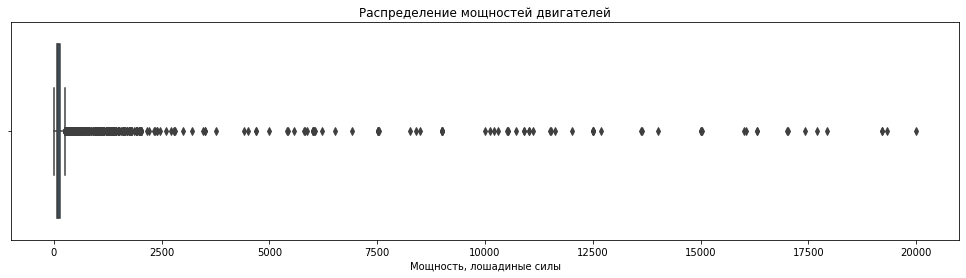

In [23]:
plt.figure(figsize=(17,4))
sns.boxplot( x=fg['Power'] )
plt.title('Распределение мощностей двигателей')
plt.xlabel('Мощность, лошадиные силы')
plt.show()

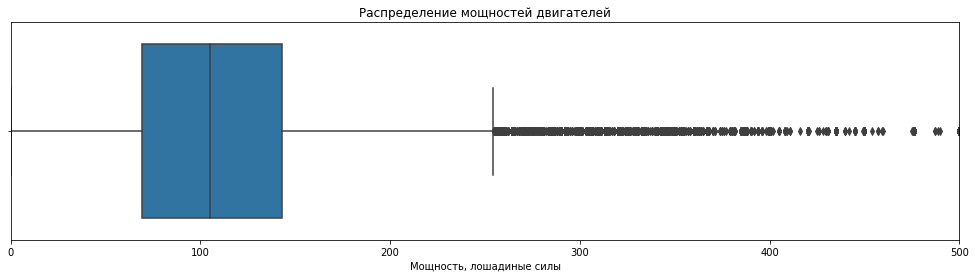

In [24]:
plt.figure(figsize=(17,4))
sns.boxplot( x=fg['Power'] )
plt.title('Распределение мощностей двигателей')
plt.xlabel('Мощность, лошадиные силы')
plt.xlim(0, 500)
plt.show()

(10, 500)

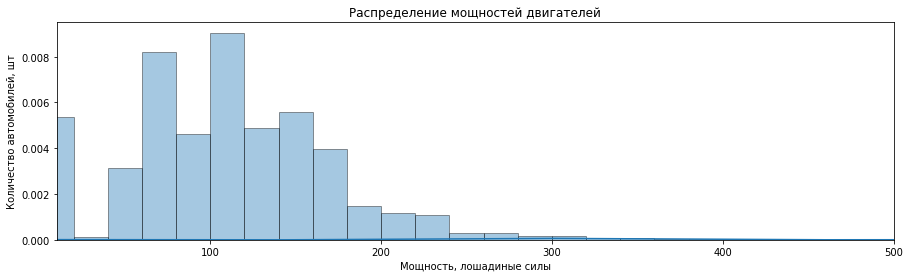

In [25]:
plt.figure(figsize=(15,4))
sns.distplot(fg['Power'], hist=True,  
             bins=1000,
             hist_kws={'edgecolor':'black'})
plt.title('Распределение мощностей двигателей')
plt.ylabel('Количество автомобилей, шт')
plt.xlabel('Мощность, лошадиные силы');
plt.xlim(10, 500)

In [26]:
fg['Power'][fg['Power'] > 500]

1816      1398
4060       953
5328      1001
6296       603
6504       771
          ... 
348968    1241
351947    1001
353493    2000
353633     650
354260    1103
Name: Power, Length: 429, dtype: int64

In [27]:
fg['Power'][fg['Power'] == 0]

0         0
15        0
32        0
37        0
54        0
         ..
354336    0
354338    0
354346    0
354363    0
354365    0
Name: Power, Length: 36360, dtype: int64

Из графиков видно, что большое количество вбросов, немного изучил вопрос и узнал, что одни из самых мощных спорткаров имеют немногим больше 1000 л/с, понятно также что есть специализированные автомобили, трактор...   
При том, что в нашем дата сете всего 429 авто с мощностью больше 500 л/с, от них можно было бы просто избавиться.  
Также нас около 10% значений 0.
Как я узнал, автомобили одной марки модели в одном кузове могут иметь разную мощность двигателя, и эта мощность играет существенную роль для владельца и следовательно отражается в цене.  
Попробуем удалить нулевые значения и значения выше 500.    
Для определения цены автомобиля по нашему алгоритму придется заполнить поле с мощностью  

In [28]:
fg = fg.query('1 <= Power <= 5000')

In [29]:
fg.isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False)

,sum,mean
Price,0.0,0.0
VehicleType,0.0,0.0
RegistrationYear,0.0,0.0
Power,0.0,0.0
Model,0.0,0.0
Kilometer,0.0,0.0
FuelType,0.0,0.0
Brand,0.0,0.0
IsManualGearbox,0.0,0.0
IsNotRepaired,0.0,0.0


In [30]:
fg

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,IsManualGearbox,IsNotRepaired
1,18300,coupe,2011,190,unknown,125000,gasoline,audi,1,1
2,9800,suv,2004,163,grand,125000,gasoline,jeep,0,1
3,1500,small,2001,75,golf,150000,petrol,volkswagen,1,0
4,3600,small,2008,69,fabia,90000,gasoline,skoda,1,0
5,650,sedan,1995,102,3er,150000,petrol,bmw,1,1
...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2016,150,159,150000,unknown,alfa_romeo,0,0
354362,3200,sedan,2004,225,leon,150000,petrol,seat,1,1
354366,1199,convertible,2000,101,fortwo,125000,petrol,smart,0,0
354367,9200,bus,1996,102,transporter,150000,gasoline,volkswagen,1,0


Уменьшим размерность хранения типа для ускорения работы

In [31]:
fg['IsNotRepaired'] = pd.to_numeric(fg['IsNotRepaired'], downcast='integer')
fg['IsManualGearbox'] = pd.to_numeric(fg['IsManualGearbox'], downcast='integer')
fg['RegistrationYear'] = pd.to_numeric(fg['RegistrationYear'], downcast='integer')
fg['Power'] = pd.to_numeric(fg['Power'], downcast='integer')
fg['Kilometer'] = pd.to_numeric(fg['Kilometer'], downcast='integer')
fg['Price'] = pd.to_numeric(fg['Price'], downcast='integer')
fg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307159 entries, 1 to 354368
Data columns (total 10 columns):
Price               307159 non-null int16
VehicleType         307159 non-null object
RegistrationYear    307159 non-null int16
Power               307159 non-null int16
Model               307159 non-null object
Kilometer           307159 non-null int32
FuelType            307159 non-null object
Brand               307159 non-null object
IsManualGearbox     307159 non-null int8
IsNotRepaired       307159 non-null int8
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 15.2+ MB


### Вывод

Загружены данные, в  таблице 354369 объектов, 16 признаков, целевой для нас Price.  
Выделены 9 значимых признаков для определения цены, остальные отброшены.  
Удалены строки с отсутствием значения целевого признака Price.  
В значимых признаках заполнены пропуски.  
В годе выпуска были заменены аномальные значения на константу.  
Признак коробки передач и восстановления заменен с категорияального на числовой.
Данные готовы к обучению.


## Обучение моделей

### Признаки

Подготовим три типа признаков для кроссвалидации:

- Неизмененные. Название original_features.
- Закодированные методом OHE. Название ohe_features.
- Закодированные методом OE. Название ordinal_features.

In [32]:
target = fg['Price']

Неизмененные данные:

In [33]:
original_features = fg.drop('Price', axis=1)

original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=12345)

Закодированные методом OE:

In [34]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features), columns=cat_features.columns, index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]
    
    
ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

Закодированные методом OHE:

In [35]:
ohe_features = pd.get_dummies(original_features, drop_first=True)

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### CatBoostRegressor

- Обучим модель на данных, закодированных по методу OE.
- Обучим на оригинальных данных с указанием категорий.

In [36]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.2, 0.5, 0.7], 'random_state':[123456], 'verbose':[False]}]
print('___Tuning hyper-parameters for RMSE___')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

CBR_ordinal_RMSE = (max(means)*-1) ** 0.5

___Tuning hyper-parameters for RMSE___

Best parameters set: {'learning_rate': 0.2, 'random_state': 123456, 'verbose': False}

Grid scores (development set):
1630.24576 for {'learning_rate': 0.2, 'random_state': 123456, 'verbose': False}
1633.41287 for {'learning_rate': 0.5, 'random_state': 123456, 'verbose': False}
1655.71968 for {'learning_rate': 0.7, 'random_state': 123456, 'verbose': False}

CPU times: user 17min 36s, sys: 3min 19s, total: 20min 55s
Wall time: 23min 17s


In [37]:
%%time
regressor = CatBoostRegressor(learning_rate=0.2, iterations = 250, random_state=123456, verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('___Train for RMSE___')
print()

CBR_original_RMSE = (cross_val_score(regressor, original_features_train, target_train, cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of CatBoostRegressor =', CBR_original_RMSE)

___Train for RMSE___

Mean RMSE from CV of CatBoostRegressor = 1679.2327366656675
CPU times: user 9min 11s, sys: 1min 56s, total: 11min 8s
Wall time: 12min 7s


### LGBMRegressor

In [66]:
%%time
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[50, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[123456]}]
print('___Tuning hyper-parameters for RMSE___')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

LGBMR_RMSE = (max(means)*-1) ** 0.5

___Tuning hyper-parameters for RMSE___

Best parameters set: {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 123456}

Grid scores (development set):
1708.52617 for {'learning_rate': 0.1, 'num_leaves': 50, 'random_state': 123456}
1659.40168 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 123456}
1625.33252 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 123456}
1657.57587 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 123456}
1632.69779 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 123456}
1624.20702 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 123456}
1673.05884 for {'learning_rate': 0.5, 'num_leaves': 50, 'random_state': 123456}
1662.22395 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 123456}
1664.55542 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 123456}

CPU times: user 15min 12s, sys: 6.12 s, total: 15min 18s
Wall time: 15min 25s


### LinearRegression

Необходимо сравнить результаты градиентного бустинга с простыми моделями. Для начала возьмем линейную регрессию.

In [63]:
%%time
regressor = LinearRegression()
print('___Train RMSE___')
print()

LR_RMSE = (cross_val_score(regressor, ohe_features_train, target_train, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of LinearRegression =', LR_RMSE)

___Train RMSE___

Mean RMSE from CV of LinearRegression = 3030.032182244037
CPU times: user 1min 26s, sys: 48.8 s, total: 2min 15s
Wall time: 2min 15s


Попробуем масштабировать данные.

In [62]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('___Train RMSE___')
print()

LR_RMSE_S = (cross_val_score(pipeline, ohe_features_train, target_train, cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of LinearRegression =', LR_RMSE_S)

___Train RMSE___

Mean RMSE from CV of LinearRegression = 2730745329972.857
CPU times: user 1min 32s, sys: 49.4 s, total: 2min 21s
Wall time: 2min 21s


Масштабирование очень сильно ухудшило ситуацию, не будем использовать.

### DecisionTreeRegressor

В заключении воспользуемся деревом решений.
Воспользуемся двумя различными типами признаков:

- OHE
- OE

In [64]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(1, 25, 3)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[123456]}]
print('___Train hyper-parameters for RMSE___')
print()


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

DTR_ohe_RMSE = (max(means)*-1) ** 0.5

___Train hyper-parameters for RMSE___

Best parameters set: {'criterion': 'mse', 'max_depth': 16, 'random_state': 123456}

Grid scores (development set):
3654.78571 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 123456}
2650.42537 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 123456}
2218.73280 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 123456}
2026.08644 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 123456}
1942.50612 for {'criterion': 'mse', 'max_depth': 13, 'random_state': 123456}
1934.21244 for {'criterion': 'mse', 'max_depth': 16, 'random_state': 123456}
1947.93075 for {'criterion': 'mse', 'max_depth': 19, 'random_state': 123456}
1963.40408 for {'criterion': 'mse', 'max_depth': 22, 'random_state': 123456}

CPU times: user 1min 42s, sys: 4.21 s, total: 1min 46s
Wall time: 1min 47s


In [65]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(1, 15)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[123456]}]
print('___Tuning hyper-parameters for RMSE___')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

DTR_ordinal_RMSE = (max(means)*-1) ** 0.5

___Tuning hyper-parameters for RMSE___

Best parameters set: {'criterion': 'mse', 'max_depth': 13, 'random_state': 123456}

Grid scores (development set):
3654.78571 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 123456}
3200.05544 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 123456}
2952.43391 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 123456}
2654.14241 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 123456}
2475.84768 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 123456}
2329.59262 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 123456}
2220.45902 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 123456}
2136.87351 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 123456}
2070.52469 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 123456}
2016.94810 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 123456}
1984.60419 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 123456}
1962.99

## Анализ моделей

Для каждой из рассмотренных моделей были выбраны лучшие гиперпараметры. Проведем обучение.

### CatBoostRegressor

Для начала обучим на данных, которые закодированы по методу OE.

In [67]:
%%time

model = CatBoostRegressor(learning_rate=0.2, random_state=123456, verbose=False) 
model.fit(ordinal_features_train, target_train)

CPU times: user 2min 26s, sys: 20.5 s, total: 2min 46s
Wall time: 2min 49s


In [68]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 169 ms, sys: 0 ns, total: 169 ms
Wall time: 123 ms


In [69]:

final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of CatBoostRegressor =', CBR_ordinal_RMSE)

final_RMSE of CatBoostRegressor = 1630.245758530857


Теперь на оригинальных.

In [70]:
%%time

model = CatBoostRegressor(learning_rate=0.2, iterations = 250, random_state=123456, verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 2min 15s, sys: 16.1 s, total: 2min 31s
Wall time: 2min 32s


In [71]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 429 ms, sys: 1.33 ms, total: 431 ms
Wall time: 424 ms


In [72]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of CatBoostRegressor =', final_RMSE_CBR_original)

final_RMSE of CatBoostRegressor = 1663.3952700829466


### LGBMRegressor

In [73]:
%%time

model = LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=123456)
model.fit(ordinal_features_train, target_train)

CPU times: user 6min 2s, sys: 2.9 s, total: 6min 5s
Wall time: 6min 7s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=200, objective=None,
              random_state=123456, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
%%time

target_predict = model.predict(ordinal_features_test)


CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.11 s


In [75]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of LGBMRegressor =', final_RMSE_LGBMR)

final_RMSE of LGBMRegressor = 1579.9949606516054


### LinearRegression

In [76]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 19.5 s, sys: 8.3 s, total: 27.8 s
Wall time: 27.8 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 57.9 ms, sys: 117 ms, total: 175 ms
Wall time: 192 ms


In [78]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of LinearRegression =', final_RMSE_LR)

final_RMSE of LinearRegression = 2997.3158965800762


### DecisionTreeRegressor

OHE

In [79]:
%%time

model = DecisionTreeRegressor(criterion='mse',  max_depth=16, random_state=123456) 
model.fit(ohe_features_train, target_train)

CPU times: user 7.58 s, sys: 119 ms, total: 7.7 s
Wall time: 7.72 s


DecisionTreeRegressor(criterion='mse', max_depth=16, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123456, splitter='best')

In [80]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 68.5 ms, sys: 58.6 ms, total: 127 ms
Wall time: 150 ms


In [81]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of DecisionTreeRegressor =', final_RMSE_DTR_ohe)

final_RMSE of DecisionTreeRegressor = 1865.3841342194362


OE

In [82]:
%%time

model = DecisionTreeRegressor(criterion='mse',  max_depth=13, random_state=123456) 
model.fit(ordinal_features_train, target_train)

CPU times: user 720 ms, sys: 0 ns, total: 720 ms
Wall time: 719 ms


DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123456, splitter='best')

In [83]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 22.5 ms, sys: 0 ns, total: 22.5 ms
Wall time: 20.7 ms


In [84]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of DecisionTreeRegressor =', final_RMSE_DTR_ordinal)

final_RMSE of DecisionTreeRegressor = 1885.9963198747478


### Сравнение

In [85]:
index = ['CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor',
         'LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features']

data = {'RMSE на CV, €':[ CBR_ordinal_RMSE,
                            CBR_original_RMSE,
                            LGBMR_RMSE,
                            LR_RMSE,
                            DTR_ohe_RMSE,
                            DTR_ordinal_RMSE],
        
        'Время обучения на CV, сек':[1397,
                                     727,
                                     925,
                                     135,                                     
                                     107,
                                     14],
        
        'RMSE модели на тестовой выборке, €':[final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR,
                                                final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal],
        'Время обучения модели, сек':[169,
                                      152,
                                      367,
                                      28,
                                      8,
                                      0.7],
        
        'Время предсказания модели, сек':[0.123,
                                          0.424,
                                          1.11,
                                          0.192,
                                          0.150,
                                          0.021]}



Regression = pd.DataFrame(data=data, index=index)   
Regression

,"RMSE на CV, €","Время обучения на CV, сек","RMSE модели на тестовой выборке, €","Время обучения модели, сек","Время предсказания модели, сек"
CatBoostRegressor on OE features,1630.245759,1397,1605.531100,169.0,0.123
CatBoostRegressor on original features,1679.232737,727,1663.395270,152.0,0.424
LGBMRegressor,1624.207015,925,1579.994961,367.0,1.110
LinearRegression,3030.032182,135,2997.315897,28.0,0.192
DecisionTreeRegressor on OHE features,1934.212443,107,1865.384134,8.0,0.150
DecisionTreeRegressor on OE features,1956.251083,14,1885.996320,0.7,0.021


Лучшей моделью по трем параметрам: качество, скорость обучения и скорость предсказания - можно считать CatBoostRegressor. Немного отстает DecisionTreeRegressor (с подготовленными признаками), но для задач, в которых необходимо бысторое решение с достаточной точностью, можно использовать. Остальные значительно отстают.
LGBMRegressor дает самый точный результат, нодолгое обучение и время предсказания.


Лучшее время обучения у DecisionTreeRegressor.